In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize
from rouge import Rouge
# from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import log_loss, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score, roc_auc_score
from malnis import show

/home/jarobyte/envs/malnis/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [3]:
data_folder = "/home/jarobyte/scratch/malnis_dataset/data/"

In [4]:
test = pd.read_pickle(data_folder + "data_test.pkl")
show(test)

(897, 9)


,query,document,summary,r1,r2,rl,sentences,relevance,original_sentences
2718,"In this paper, we propose a novel neural netwo...","Index Terms—Deep Learning, Graph Neural Networ...",[There are several works attempting to use the...,0.276680,0.121053,0.260870,"[Index Terms—Deep Learning, Graph Neural Netwo...","[False, False, False, False, False, False, Fal...",622
3198,LSTMs and other RNN variants have shown strong...,Machine learning systems now excel (in expecta...,"[(2015), current byte-level LMs are not compet...",0.278351,0.120968,0.268041,[Machine learning systems now excel (in expect...,"[False, False, False, False, False, False, Fal...",257
4793,We propose a deep learning framework for model...,In this work we consider the task of solving g...,[With recent advance in the normalizing flow c...,0.259366,0.105675,0.247839,[In this work we consider the task of solving ...,"[False, False, False, False, False, False, Fal...",216
6978,Inspired by recent work in machine translation...,1077-2626 2017 IEEE. Personal use is permitted...,[[32] use attention to identify important aspe...,0.248588,0.110169,0.248588,"[1077-2626 2017 IEEE., Personal use is permitt...","[False, False, False, False, False, False, Fal...",1031
1773,"Continuous word representations, trained on la...",‘Nested Entities’ are named entities containin...,"[To encode words, we use both BERTLarge and fa...",0.315789,0.105882,0.289474,[‘Nested Entities’ are named entities containi...,"[False, False, False, False, False, True, Fals...",136


In [5]:
true_targets = np.concatenate(test.relevance.to_list())
print("true targets", true_targets.shape)

true targets (261439,)


In [6]:
records = test.to_dict("records")
len(records)

897

In [7]:
output_folder = "/home/jarobyte/scratch/malnis_dataset/data/classical_models_test/"

# TFIDF

In [8]:
%%time

predictions = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer()
    sentences = d["sentences"]
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevance = (query_emb @ features.T).toarray().squeeze()
#     print(relevance.shape)
    predictions.append(relevance)

true_predictions = np.concatenate(predictions)
print("true predictions", true_predictions.shape)

np.save(output_folder + "tfidf_words.npy", true_predictions)

# fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# display = PrecisionRecallDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Words",
#     ax = axes[0]
# )

# display = RocCurveDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Words",
#     ax = axes[1]
# )

  0%|          | 0/897 [00:00<?, ?it/s]

true predictions (261439,)
CPU times: user 5.41 s, sys: 24.3 ms, total: 5.43 s
Wall time: 5.49 s


In [9]:
%%time

#chars

predictions = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer(
        analyzer = "char",
        ngram_range = (3, 3)
    )    
    sentences = d["sentences"]
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevance = (query_emb @ features.T).toarray().squeeze()
#     print(relevance.shape)
    predictions.append(relevance)

true_predictions = np.concatenate(predictions)
print("true predictions", true_predictions.shape)

np.save(output_folder + "tfidf_chars.npy", true_predictions)

# fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# display = PrecisionRecallDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Chars",
#     ax = axes[0]
# )

# display = RocCurveDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Chars",
#     ax = axes[1]
# )

  0%|          | 0/897 [00:00<?, ?it/s]

true predictions (261439,)
CPU times: user 17.3 s, sys: 41.3 ms, total: 17.4 s
Wall time: 17.4 s


# Sentence-BERT

In [10]:
X_test = np.load(data_folder + "embeddings/sbert/X_test.npy")
X_test.shape

(897, 512, 768)

In [11]:
Y_test = np.load(data_folder + "embeddings/sbert/Y_test.npy")
Y_test.shape

(897, 512)

In [12]:
queries = X_test[:, :, :384]
queries.shape

(897, 512, 384)

In [13]:
sentences = X_test[:, :, 384:]
sentences.shape

(897, 512, 384)

In [14]:
product = (queries * sentences).sum(-1)
product.shape

(897, 512)

In [15]:
product.min(), product.max()

(-0.20886484, 0.86291116)

In [16]:
product[product < 0] = 0

product.min(), product.max()

(0.0, 0.86291116)

In [17]:
true_predictions = np.concatenate([p[:l] for l, p in zip(tqdm(test.original_sentences), product)])
true_predictions.shape

  0%|          | 0/897 [00:00<?, ?it/s]

(261439,)

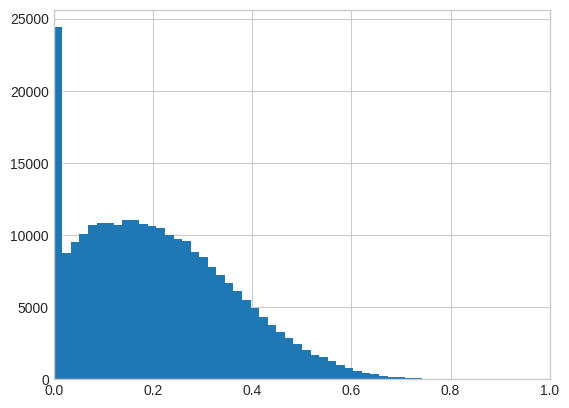

In [18]:
plt.hist(
    true_predictions,
    bins = 50
)
plt.xlim(0, 1)
plt.show()

In [19]:
np.save(output_folder + "sbert.npy", true_predictions)

In [20]:
targets = np.concatenate(test.relevance.to_list())
print("targets", targets.shape)

targets (261439,)


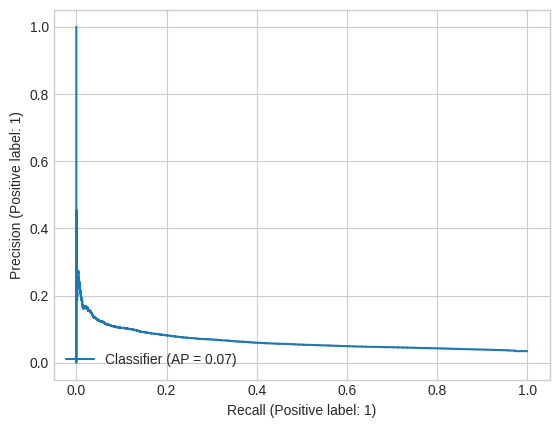

In [21]:
PrecisionRecallDisplay.from_predictions(targets, true_predictions)
plt.show()

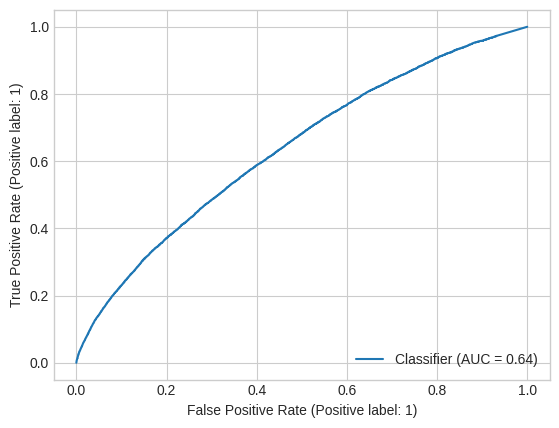

In [22]:
RocCurveDisplay.from_predictions(targets, true_predictions)
plt.show()

# SPECTER

In [23]:
X_test = np.load(data_folder + "embeddings/specter/X_test.npy")
X_test.shape

(897, 512, 1536)

In [24]:
Y_test = np.load(data_folder + "embeddings/specter/Y_test.npy")
Y_test.shape

(897, 512)

In [25]:
queries = X_test[:, :, :768]
queries.shape

(897, 512, 768)

In [26]:
sentences = X_test[:, :, 768:]
sentences.shape

(897, 512, 768)

In [27]:
distances = ((queries - sentences) ** 2).sum(-1)
distances.shape

(897, 512)

In [28]:
distances.min(), distances.mean(), distances.max()

(0.0, 139.08423, 680.1081)

  0%|          | 0/897 [00:00<?, ?it/s]

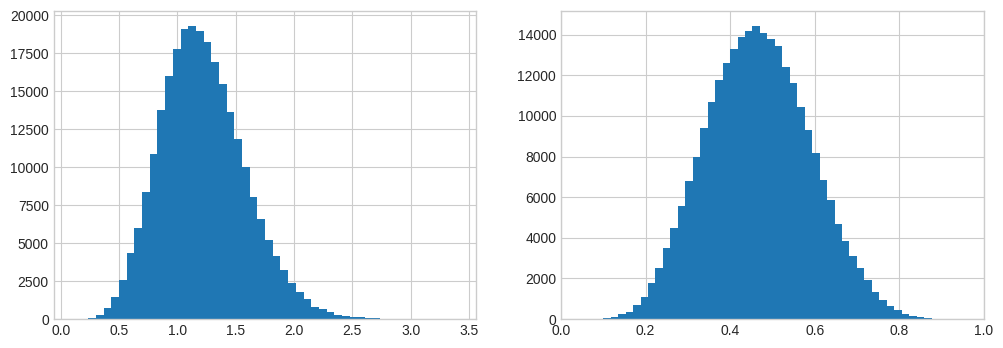

In [29]:
unpadded_distances = np.concatenate([p[:l] for l, p in zip(tqdm(test.original_sentences), distances)])
unpadded_distances = unpadded_distances / 200

# true_predictions = 1 / (1 + (10**-3) * unpadded_distances)
# true_predictions = 1 / (1 + (10**-2.5) * unpadded_distances)
true_predictions = 2 / (1 + np.exp(unpadded_distances))

# true_predictions.shape

f, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(unpadded_distances, bins = 50)
axes[1].hist(true_predictions, bins = 50)
axes[1].set_xlim(0, 1)
plt.show()

In [30]:
true_predictions

array([0.63987786, 0.5366538 , 0.51754326, ..., 0.37346303, 0.39332628,
       0.416088  ], dtype=float32)

In [31]:
2 / (1 + np.exp(unpadded_distances / 2000))

array([0.9998115 , 0.99974924, 0.99973685, ..., 0.9996321 , 0.9996482 ,
       0.99966586], dtype=float32)

# $\frac{1}{\beta + \alpha x}$

In [32]:
alpha = np.linspace(0.1, 3, 30)
beta = np.linspace(0.5, 5, 40)

In [33]:
predictions = 1 / (beta.reshape(-1, 1, 1) + alpha.reshape(-1, 1) * unpadded_distances)
predictions.shape

(40, 30, 261439)

In [34]:
scores = [average_precision_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/40 [00:00<?, ?it/s]

count    1.200000e+03
mean     5.127130e-02
std      2.082536e-17
min      5.127130e-02
25%      5.127130e-02
50%      5.127130e-02
75%      5.127130e-02
max      5.127130e-02
dtype: float64

In [35]:
scores = [roc_auc_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/40 [00:00<?, ?it/s]

count    1.200000e+03
mean     5.787240e-01
std      1.110686e-16
min      5.787240e-01
25%      5.787240e-01
50%      5.787240e-01
75%      5.787240e-01
max      5.787240e-01
dtype: float64

# $\frac{2}{1 + e ^ {a + b x}}$

In [36]:
A = np.linspace(0.1, 10, 12)
B = np.linspace(0.1, 10, 13)
# C = np.linspace(0.1, 10, 14)

In [37]:
predictions = 2 / (1 + np.exp((B.reshape(-1, 1, 1) + A.reshape(-1, 1) * unpadded_distances)))
predictions.shape

(13, 12, 261439)

In [38]:
predictions.min(), predictions.mean(), np.median(predictions), predictions.max()

(1.5478400280431062e-19,
 0.02177643415171314,
 3.7544723891876114e-05,
 0.9447737674593716)

In [39]:
scores = [average_precision_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/13 [00:00<?, ?it/s]

count    1.560000e+02
mean     5.127130e-02
std      1.392248e-17
min      5.127130e-02
25%      5.127130e-02
50%      5.127130e-02
75%      5.127130e-02
max      5.127130e-02
dtype: float64

In [40]:
scores = [roc_auc_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/13 [00:00<?, ?it/s]

count    1.560000e+02
mean     5.787240e-01
std      2.227597e-16
min      5.787240e-01
25%      5.787240e-01
50%      5.787240e-01
75%      5.787240e-01
max      5.787240e-01
dtype: float64

# plots

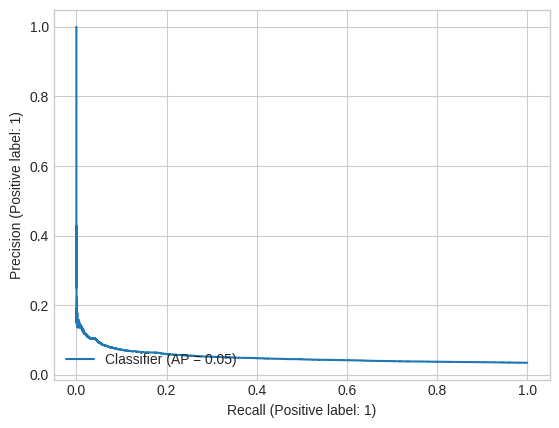

In [41]:
PrecisionRecallDisplay.from_predictions(targets, true_predictions)
plt.show()

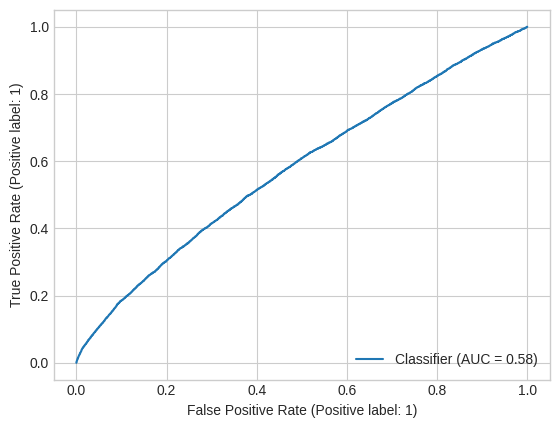

In [42]:
RocCurveDisplay.from_predictions(targets, true_predictions)
plt.show()

In [43]:
np.save(output_folder + "specter.npy", true_predictions)